In [1]:
# libraries
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from random import shuffle  
from PIL import Image
import cv2
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Model
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
tf.__version__

'2.8.0'

Loading Zip dataset from google drive

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [5]:
fid = drive.ListFile({'q':"title='Medical_MNIST.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id':fid})
f.GetContentFile('Medical_MNIST.zip')


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

In [6]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

Unzipping the Medical MNIST dataset

In [7]:
!unzip Medical_MNIST.zip

Streaming output truncated to the last 5000 lines.
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005000.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005001.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005002.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005003.jpeg  
  inflating: Medical_MNIST/MedicalMNIST/HeadCT/005004.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005005.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005006.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005007.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005008.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005009.jpeg  
  inflating: Medical_MNIST/MedicalMNIST/HeadCT/005010.jpeg  
  inflating: Medical_MNIST/MedicalMNIST/HeadCT/005011.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005012.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005013.jpeg  
 extracting: Medical_MNIST/MedicalMNIST/HeadCT/005014.jpeg  
 extracting: Medical_MNIST/Medical

In [5]:
PATH = '/content/Medical_MNIST'

In [6]:
os.listdir(PATH)


['MedicalMNIST']

Data Prep

In [7]:
medical_dir = os.path.join(PATH, 'MedicalMNIST')

In [9]:
classes = {'AbdomenCT': 0, 'BreastMRI': 1, 'ChestCT': 2, 'CXR': 3, 'Hand': 4, 'HeadCT': 5}

In [8]:
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE=64
N_CLASSES = 6
EPOCHS = 5

In [10]:
abdomen_DIR='/content/Medical_MNIST/MedicalMNIST/AbdomenCT'
breastmri_DIR='/content/Medical_MNIST/MedicalMNIST/BreastMRI'
chestct_DIR='/content/Medical_MNIST/MedicalMNIST/ChestCT'
cxr_DIR='/content/Medical_MNIST/MedicalMNIST/CXR'
hand_DIR='/content/Medical_MNIST/MedicalMNIST/Hand'
headct = '/content/Medical_MNIST/MedicalMNIST/HeadCT'

combining the images for training

In [11]:
def assign_label(img,class_type):
    return class_type

X = []
y = []

def make_train_data(class_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,class_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(str(label))

In [12]:
make_train_data(classes.get('AbdomenCT'), abdomen_DIR)

100%|██████████| 10000/10000 [00:07<00:00, 1285.01it/s]


In [13]:
make_train_data(classes.get('BreastMRI'), breastmri_DIR)

100%|██████████| 8954/8954 [00:06<00:00, 1349.13it/s]


In [14]:
make_train_data(classes.get('ChestCT'), chestct_DIR)

100%|██████████| 10000/10000 [00:07<00:00, 1371.36it/s]


In [15]:
make_train_data(classes.get('CXR'), cxr_DIR)

100%|██████████| 10000/10000 [00:07<00:00, 1309.50it/s]


In [16]:
make_train_data(classes.get('Hand'), hand_DIR)

100%|██████████| 10000/10000 [00:03<00:00, 2838.94it/s]


In [17]:
make_train_data(classes.get('HeadCT'), headct)

100%|██████████| 10000/10000 [00:02<00:00, 4597.16it/s]


In [18]:
len(X)
y = np.array(y)
X = np.array(X)
X.shape

(58954, 64, 64, 3)

In [19]:
X.shape, y.shape

((58954, 64, 64, 3), (58954,))

spliting the dataset into train and test

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=58954)

In [21]:
k = len(set(y_train))
print("Number of classes, ", k)

Number of classes,  6


In [22]:
X_train = X_train.astype('float64')/255
X_test = X_test.astype('float64')/255

In [23]:
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

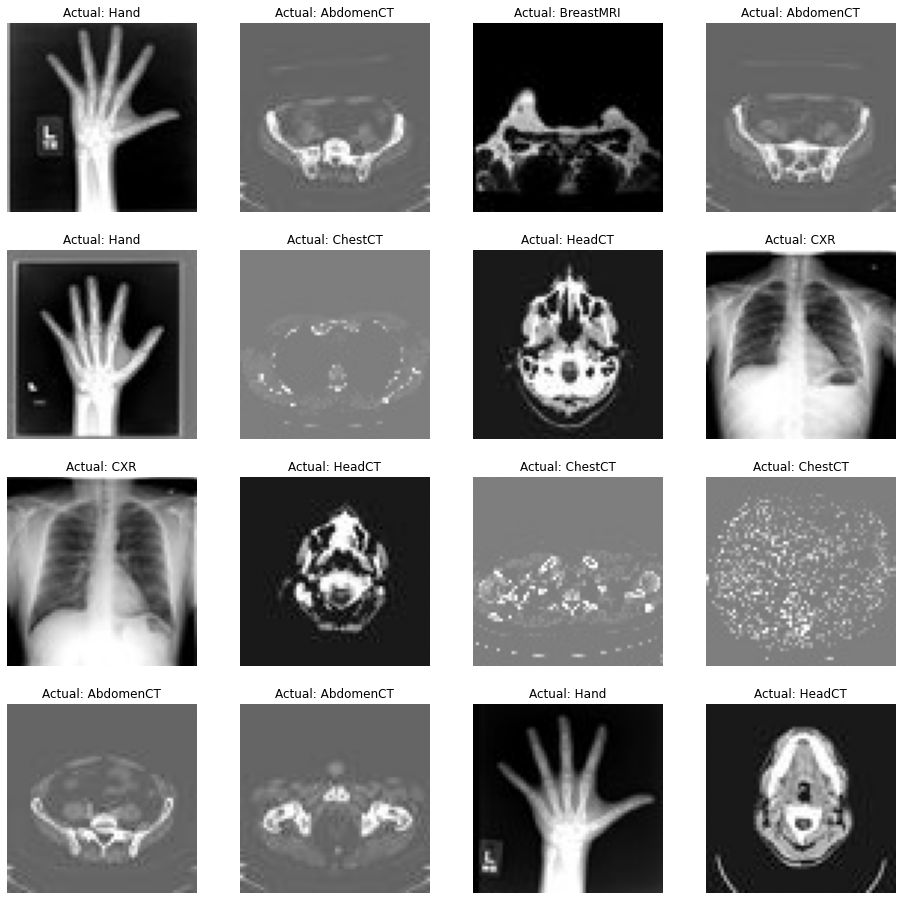

In [24]:
labels = '''AbdomenCT
BreastMRI
ChestCT
CXR
Hand
HeadCT'''.split("\n")

plt.figure(figsize=(16,16))
j = 1
for i in np.random.randint(0,1000,16):
    plt.subplot(4,4,j); j+=1
    plt.imshow(X_train[i],cmap = 'Greys')
    plt.axis('off')
    plt.title("Actual: {}".format(labels[np.argmax(y_train[i])]))

Neural Nwtwork

In [34]:
i = layers.Input(shape = (X_train[0].shape))
x = layers.Conv2D(64, (3,3), activation='relu', strides = (2,2), padding= 'same')(i)
x = layers.Conv2D(64, (3,3), activation='relu', strides = (2,2), padding= 'same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', strides = (2,2), padding= 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='elu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='elu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(k, activation='softmax')(x)

model = Model(i, x)

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0   

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, min_lr=0.00001)

model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=  (X_test,y_test), callbacks=[reduce_lr])

The class of this is: 3


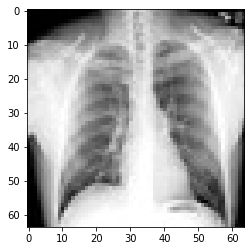

In [27]:
print("The class of this is: {}".format(np.argmax(y_train[10])))
plt.imshow(X_train[10], cmap='gray')
plt.show()

Confusion matrix, without normalization
[[ 988    0    0    0    0    0]
 [   0  885    0    0    0    0]
 [   0    0 1010    0    0    0]
 [   0    0    0  951    1    0]
 [   0    0    0    1 1031    0]
 [   0    0    0    0    0 1029]]


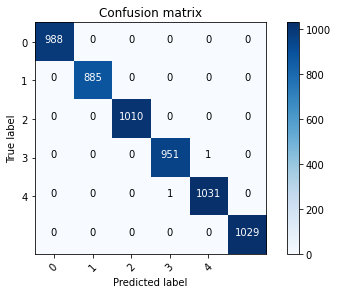

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(np.argmax(y_test, axis= 1), p_test)
plot_confusion_matrix(cm, list(range(5)))

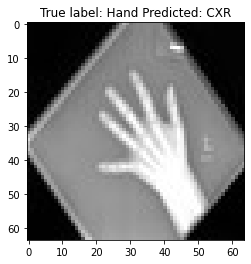

In [33]:
misclassified_idx = np.where(p_test != np.argmax(y_test, axis= 1))[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[np.argmax(y_test[i])], labels[p_test[i]]));